In [51]:
from types import MethodType

import torch
from diffusers import StableDiffusionControlNetPipeline, DDIMScheduler, AutoencoderKL, ControlNetModel
from diffusers import StableDiffusionControlNetInpaintPipeline
from PIL import Image

from ip_adapter import IPAdapter
from ip_adapter.utils import register_cross_attention_hook # ?

In [14]:
root_path = "/media/raid/santiagojn/IPAdapter/"
base_model_path = root_path + "stable-diffusion-v1-5"
vae_model_path = root_path + "sd-vae-ft-mse"
image_encoder_path = root_path + "models/image_encoder/"
ip_ckpt = root_path + "models/ip-adapter_sd15.bin"
device = "cuda"

In [15]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)

## ControlNet Depth

In [23]:
# load controlnet
controlnet_model_path = root_path + "control_v11f1p_sd15_depth"
controlnet = ControlNetModel.from_pretrained(controlnet_model_path, torch_dtype=torch.float16)
# load SD pipeline
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    base_model_path,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00,  6.50it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


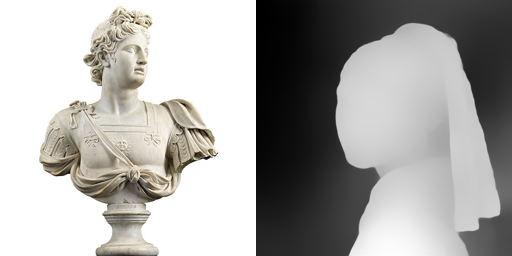

In [24]:
# read image prompt
image = Image.open("assets/images/statue.png")
depth_map = Image.open("assets/structure_controls/depth.png")
image_grid([image.resize((256, 256)), depth_map.resize((256, 256))], 1, 2)

In [25]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

100%|██████████| 50/50 [00:08<00:00,  6.11it/s]


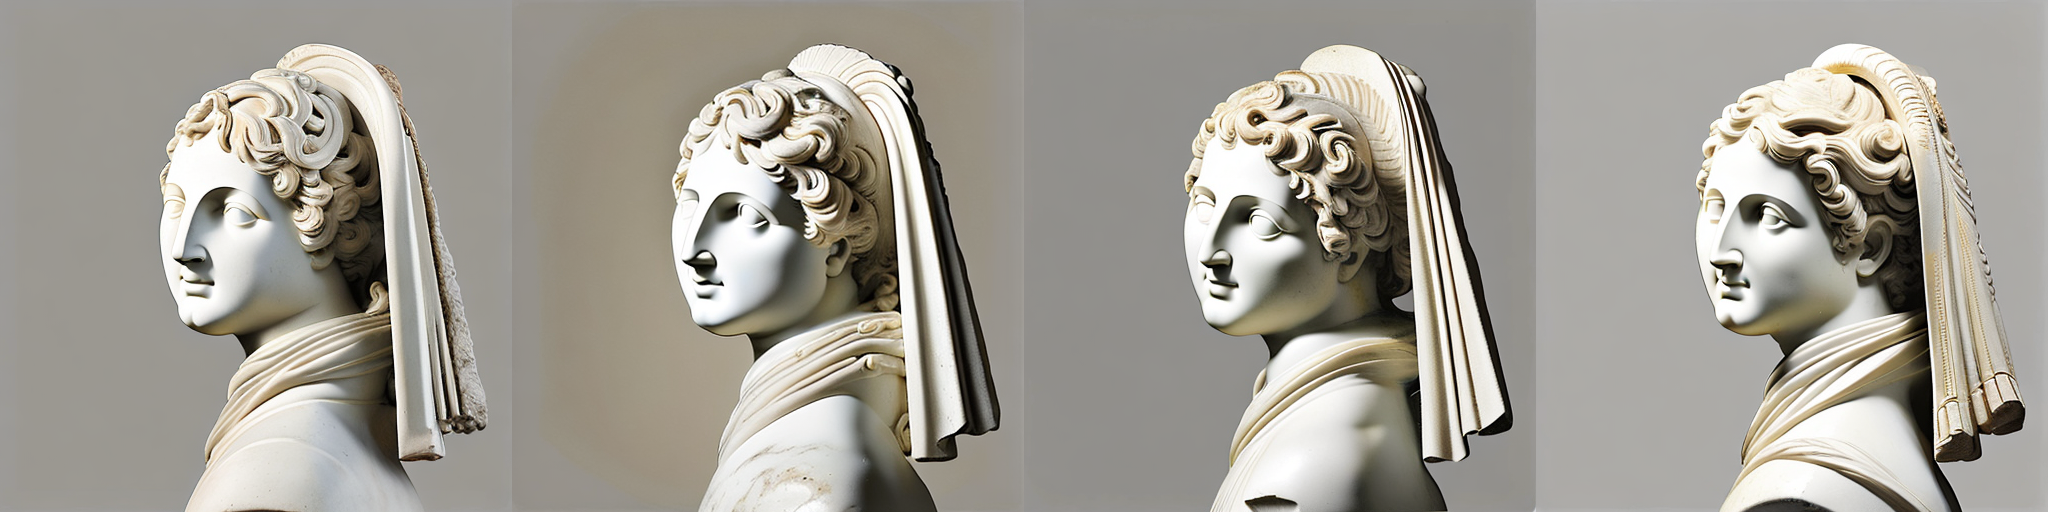

In [26]:
# generate image variations
images = ip_model.generate(pil_image=image, image=depth_map, num_samples=4, num_inference_steps=50)#, seed=42)
grid = image_grid(images, 1, 4)
grid

## ControlNet Inpainting (with our images)

In [52]:
# load SD pipe
# del pipe, ip_model
torch.cuda.empty_cache()

# load controlnet
controlnet_model_path = root_path + "control_v11p_sd15_normalbae"
controlnet = ControlNetModel.from_pretrained(controlnet_model_path, torch_dtype=torch.float16)
# load SD pipeline
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    base_model_path,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)
pipe.unet = register_cross_attention_hook(pipe.unet) # TODO: Ver qué hace esto

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00,  7.18it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_inpaint.StableDiffusionControlNetInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


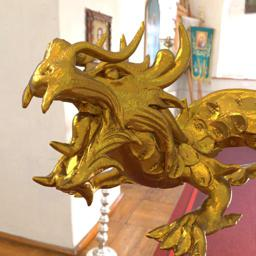

In [84]:
# read image prompt
image = Image.open("assets/images/dragon1.jpg")
image.resize((256, 256))

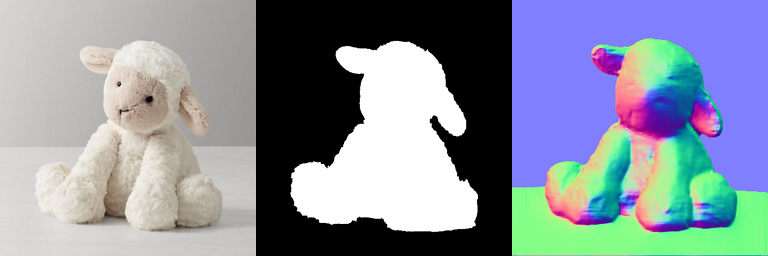

In [90]:
masked_image = Image.open("assets/inpainting/toy_image.jpg").resize((256, 256))
mask = Image.open("assets/inpainting/toy_mask.png").resize((256, 256))
normals = Image.open("assets/inpainting/toy_normals.png").resize((256, 256))
image_grid([masked_image.resize((256, 256)), mask.resize((256, 256)), normals], 1, 3)

In [55]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

100%|██████████| 100/100 [00:07<00:00, 13.50it/s]


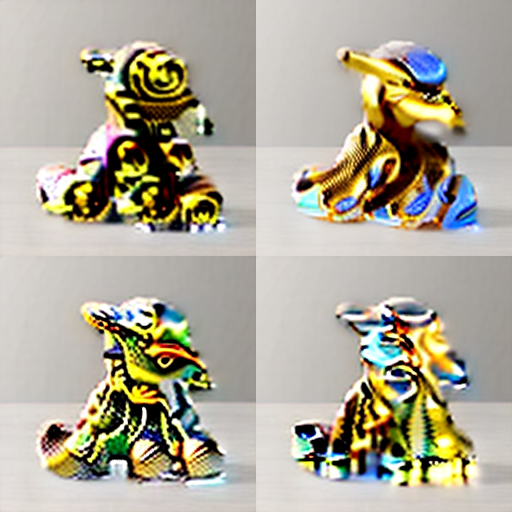

In [92]:
# generate
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=100, control_image=normals, seed=48,
                           image=masked_image, mask_image=mask, controlnet_conditioning_scale=0.8 )
grid = image_grid(images, 2, 2)
grid
# images[0]

## ControlNet OpenPose _(not downloaded)_

In [ ]:
# load SD pipe
del pipe, ip_model
torch.cuda.empty_cache()
# load controlnet
controlnet_model_path = root_path + "control_v11p_sd15_openpose"
controlnet = ControlNetModel.from_pretrained(controlnet_model_path, torch_dtype=torch.float16)
# load SD pipeline
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    base_model_path,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

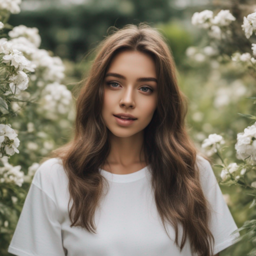

In [ ]:
# read image prompt
image = Image.open("assets/images/girl.png")
image.resize((256, 256))

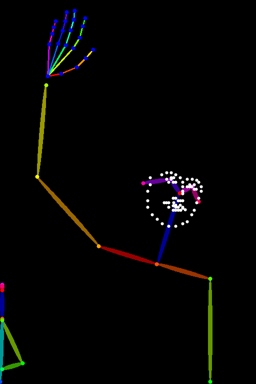

In [ ]:
openpose_image = Image.open("assets/structure_controls/openpose.png")
openpose_image.resize((256, 384))

In [ ]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

  0%|          | 0/50 [00:00<?, ?it/s]

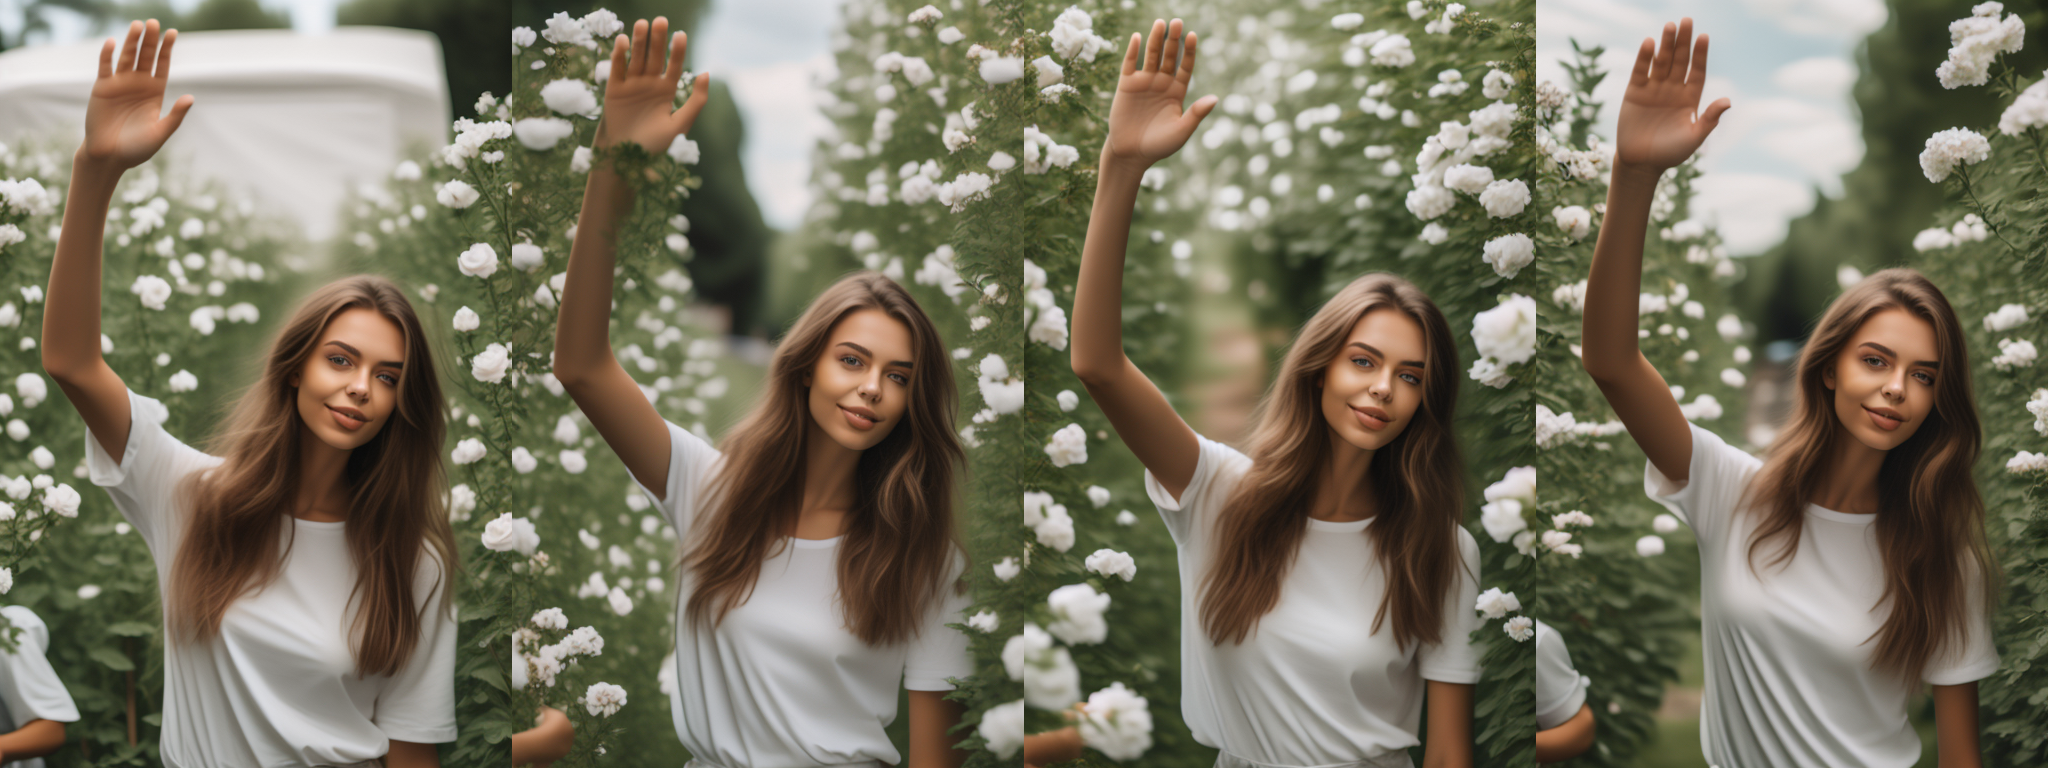

In [ ]:
# generate
images = ip_model.generate(pil_image=image, image=openpose_image, width=512, height=768, num_samples=4, num_inference_steps=50, seed=42)
grid = image_grid(images, 1, 4)
grid